# Обработка высококореллированных признаков

В настоящей тетради мы рассмотрим методы фильтрации признаков на основе дисперсии и корелляции для улучшения качества моделей машинного обучения.

***

## Знакомство с методами

В общих чертах ознакомимся с методами фильтрации признаков.

### Фильтрация на основе дисперсии

Фильтрация признаков на основе дисперсии включает в себя выбор признаков на основе их коэффициента дисперсии, который является мерой того, насколько разбросаны значения признака. Коэффициент дисперсии определяется как отношение среднего арифметического к среднему геометрическому для данного признака. Это соотношение колеблется от +1 до бесконечности, и более высокий коэффициент дисперсии подразумевает более релевантный признак. И наоборот, когда все выборки признаков имеют (примерно) одинаковое значение, коэффициент дисперсии близок к 1, что указывает на низкую релевантность признака.

### Фильтрация на основе корреляции

Фильтрация признаков на основе корреляции включает в себя выбор признаков на основе их корреляции с целевой переменной. Корреляция между признаком и целевой переменной является мерой силы и направления линейной зависимости между ними. Этот метод направлен на выявление признаков, которые имеют сильную линейную связь с целевой переменной, что делает их потенциально более релевантными для задач прогнозного моделирования.

Наиболее часто используемой мерой корреляции для выбора признака является коэффициент корреляции Пирсона, который количественно определяет линейную зависимость между двумя непрерывными переменными. Коэффициент корреляции Пирсона колеблется от -1 до 1, где 1 указывает на идеальную положительную линейную зависимость, -1 указывает на идеальную отрицательную линейную зависимость, а 0 указывает на отсутствие линейной зависимости.

Важно заметить, что когда зависимость между признаком и целевой переменной не является линейной, данный метод фильтрации может и вовсе не распознать эту зависисмость. Поэтому в таких случаях лучше будет воспользоваться, к примеру, взаимной информацией.

***

## Практические примеры

Рассмотрим теперь, как на практике можно применить рассмотренные выше методы фильтрации.

Но прежде как обычно выполним необходимые импорты и рутинную обработку данных.

In [1]:
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
from numpy import ndarray
from pandas import read_csv
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

В качестве выборки возьмём оценки качества красного вина.

In [2]:
wine = read_csv("../datasets/winequality_red.csv")

wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Разделим набор данных на тренировочные и тестовые выборки.

In [3]:
x_train_wine, x_test_wine, y_train_wine, y_test_wine = train_test_split(
    wine.iloc[:, :-1],
    wine.iloc[:, -1],
    test_size=0.35,
    random_state=52,
)

### Порог коэффициента дисперсии

Инициализируем экземпляр класса-фильтра `VarianceThreshold` и применим его. Признаки имеющие коэффициент дисперсии меншьший, чем пороговое значение, будут исключены. Масштабируем данные и обучим модель логистической регрессии. Код для всего процесса обернём в функцию.

In [4]:
def fit_predict_evaluate_variance_model(
    x_train: ndarray,
    x_test: ndarray,
    y_train: ndarray,
    y_test: ndarray,
    *,
    variance_threshold: float,
) -> float:
    selector = VarianceThreshold(threshold=variance_threshold)
    selector.fit(x_train_wine)
    x_train_selected = selector.transform(x_train_wine)
    x_test_selected = selector.transform(x_test_wine)

    scaler = MinMaxScaler()
    scaler.fit(x_train_selected)
    x_train_scaled = scaler.transform(x_train_selected)
    x_test_scaled = scaler.transform(x_test_selected)

    regressor = LogisticRegression()
    regressor.fit(x_train_scaled, y_train)
    y_predicted = regressor.predict(x_test_scaled)
    error = float(mean_absolute_percentage_error(y_predicted, y_test))

    return error

Установим пороговое значение коэффициента дисперсии равным 0,5.

In [5]:
fit_predict_evaluate_variance_model(
    x_train_wine,
    x_test_wine,
    y_train_wine,
    y_test_wine,
    variance_threshold=0.5,
)

0.09218537414965987

Увеличим пороговое значение дисперсии до 0,7.

In [6]:
fit_predict_evaluate_variance_model(
    x_train_wine,
    x_test_wine,
    y_train_wine,
    y_test_wine,
    variance_threshold=0.7,
)

0.09218537414965987

И понизим до 0,2.

In [7]:
fit_predict_evaluate_variance_model(
    x_train_wine,
    x_test_wine,
    y_train_wine,
    y_test_wine,
    variance_threshold=0.2,
)

0.09218537414965987

Как это ни странно, результат никак не меняется, и не важно, каково пороговое значение дисперсии...

### Порог коэффициента корреляции

Сейчас мы опишем небольшой класс подобно тем, что мы можем видеть в Scikit-Learn, для вычисления корреляции признаков и их исключения на основе порогового значения.

In [8]:
class CorrelationFilter:
    def __init__(self, threshold=0.95):
        self.threshold = threshold
        self.highly_correlated_indices = []

    def fit(self, x) -> None:
        correlation_matrix = np.corrcoef(x, rowvar=False)
        num_features = correlation_matrix.shape[0]

        # Create a mask to identify highly correlated features
        high_correlation_mask = np.abs(correlation_matrix) > self.threshold
        np.fill_diagonal(high_correlation_mask, False)  # Exclude self-correlation

        # Identify indices of highly correlated features
        self.highly_correlated_indices = [
            i for i in range(num_features) if np.any(high_correlation_mask[i])
        ]

    def transform(self, x) -> ndarray:
        # Drop highly correlated features
        filtered_features = np.delete(x, self.highly_correlated_indices, axis=1)
        return filtered_features

    def fit_transform(self, x) -> ndarray:
        self.fit(x)
        filtered_features = self.transform(x)
        return filtered_features

Так как метод включает в себя вычисление матрицы корреляции, полезно будет взглянуть на неё. Код для визуализации заворачиваем в функцию.

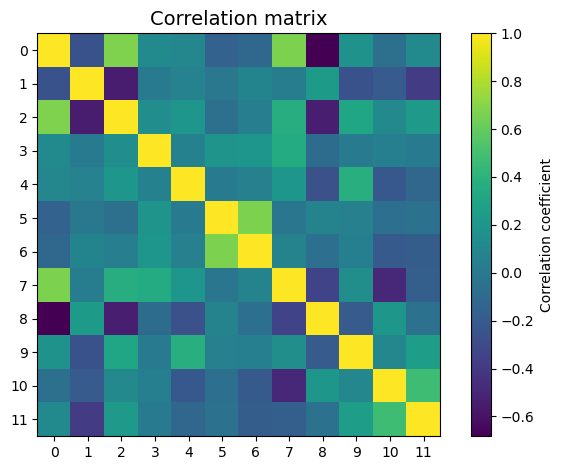

In [9]:
def draw_correlation_matrix(data: ndarray, threshold: Optional[float] = None) -> None:
    correlation_matrix = np.corrcoef(data, rowvar=False)

    fig = plt.figure()
    axis = fig.add_subplot()
    matrix = plt.imshow(correlation_matrix)
    colorbar = fig.colorbar(matrix)

    ticks = tuple(range(correlation_matrix.shape[0]))
    axis.set_xticks(ticks)
    axis.set_yticks(ticks)

    title = "Correlation matrix"
    if threshold:
        title += f" (threshold = {threshold})"
    axis.set_title(title, fontsize=14)
    colorbar.set_label("Correlation coefficient")
    plt.tight_layout()
    plt.show()


wine_numpy = wine.to_numpy()
draw_correlation_matrix(wine_numpy)

Так же, как и пороговым значением дисперсии, определим функцию, которая выполнит фильтрацию признаков, масштабирует данные и обучит модель.

In [10]:
def fit_predict_evaluate_correlation_model(
    x_train: ndarray,
    x_test: ndarray,
    y_train: ndarray,
    y_test: ndarray,
    *,
    correlation_threshold: float,
) -> float:
    selector = CorrelationFilter(threshold=correlation_threshold)
    selector.fit(x_train_wine)
    x_train_selected = selector.transform(x_train_wine)
    x_test_selected = selector.transform(x_test_wine)

    scaler = MinMaxScaler()
    scaler.fit(x_train_selected)
    x_train_scaled = scaler.transform(x_train_selected)
    x_test_scaled = scaler.transform(x_test_selected)

    regressor = LogisticRegression()
    regressor.fit(x_train_scaled, y_train)
    y_predicted = regressor.predict(x_test_scaled)
    error = float(mean_absolute_percentage_error(y_predicted, y_test))

    return error

Оставим для начала пороговое значение по умолчанию.

In [11]:
fit_predict_evaluate_correlation_model(
    x_train_wine,
    x_test_wine,
    y_train_wine,
    y_test_wine,
    correlation_threshold=0.95,
)

0.08500850340136054

Понизим значение до 0,65.

In [12]:
fit_predict_evaluate_correlation_model(
    x_train_wine,
    x_test_wine,
    y_train_wine,
    y_test_wine,
    correlation_threshold=0.65,
)

0.08796768707482992

А теперь и вовсе до 0,5!

In [13]:
fit_predict_evaluate_correlation_model(
    x_train_wine,
    x_test_wine,
    y_train_wine,
    y_test_wine,
    correlation_threshold=0.5,
)

0.10579931972789115

Как видим, на этот раз изменение порогового значения коэффициента всё-же повлияло на точность модели. Рассмотрим теперь соответствующие матрицы корреляции.

Вот матрица для порогового значения коэффициента корреляции равного 0,95.

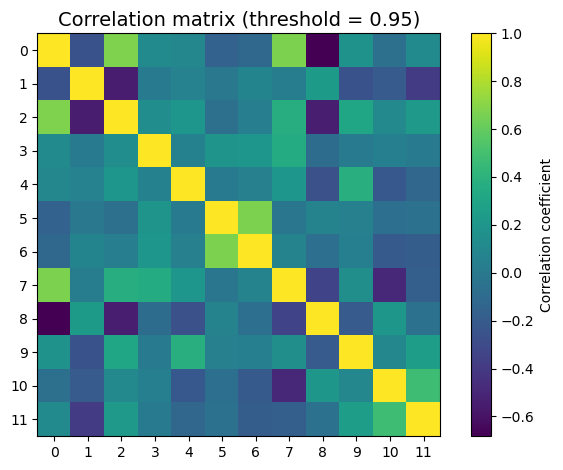

In [14]:
correlation_filter = CorrelationFilter()

wine_selected = correlation_filter.fit_transform(wine_numpy)
draw_correlation_matrix(wine_selected, 0.95)

Матрица для порога в 0,65:

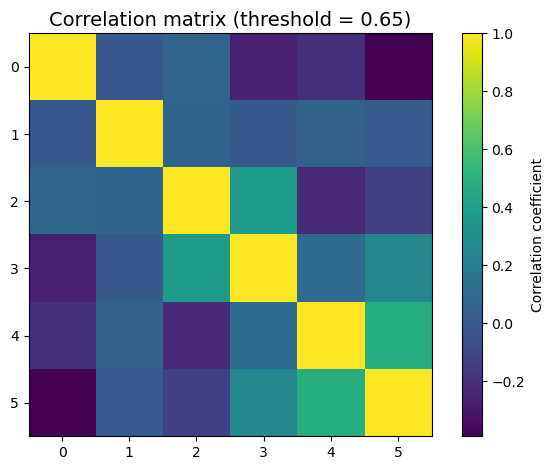

In [15]:
correlation_filter = CorrelationFilter(threshold=0.65)

wine_selected = correlation_filter.fit_transform(wine_numpy)
draw_correlation_matrix(wine_selected, 0.65)

И, наконец, для 0,5 имеем:

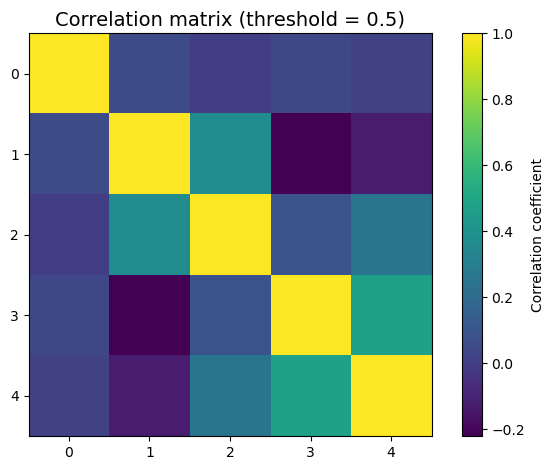

In [16]:
correlation_filter = CorrelationFilter(threshold=0.5)

wine_selected = correlation_filter.fit_transform(wine_numpy)
draw_correlation_matrix(wine_selected, 0.5)

Нетрудно видеть, что пороговое значение коэффициента корреляции равное 0,95 не оказывает никакого влияния на матрицу корреляции. Однако чем более радикально низкие значения для самого порога мы берём, тем (что не удивительно) фильтр больше исключает признаков.

***

## Заключение

В настоящей тетради мы познакомились с двумя новыми методами фильтрации признаков, а именно: фильтрации по пороговому значению дисперсии и корреляции. Эти методы являются довольно полезными при работе с данными, в которых довольно много высококоррелированных признаков. И теперь мы знаем, как можно ими пользоваться для повышения уровня качества моделей машинного обучения. (Пускай, здесь мы наблюдали только упадки качества в показательных целях.)